# Mini Chinese Input Method Editor with Pinyin Spelling Corrector
## Discovery and Discussion Notebook
I was inspired after reading Peter Norvig's chapter in the book, *Beautiful Data* on Natural Language Corpus Data, and subsequently his [implementation](https://norvig.com/spell-correct.html) of a spelling corrector, and I wondered if I could implement a similar spell corrector for pinyin, with the corrected pinyin being used to suggest individual characters, as a primitive Chinese input method editor would do. The syllable (pinyin without tones) and character frequency lists were taken from [Jun Da](http://lingua.mtsu.edu/chinese-computing/) at Middle Tennessee State University. While I am a linguistics minor who is interested in natural language processing, I do not have any significant experience in it besides messing around with NLTK a little bit. I started this project out of curiosity without much expectation, but I figured that nonetheless, it would be an interesting learning experience. I also wanted to use this opportunity to explore how to make Jupyter notebooks more interactive by learning how to use ipywidgets.

Intended Organization of the [Repository](https://github.com/rtang18/xiaoshuru):
- [notebooks](https://github.com/rtang18/xiaoshuru/notebooks):
    - Discovery and Discussion Notebook (what you're looking at!): Includes thought process, exploratory visualizations, first implementations.
    - Report Notebook: Report outlining the project.
    - Interface Notebooks: Notebooks with only the IME widgets.
- [scripts](https://github.com/rtang18/xiaoshuru/scripts): Python scripts of the implementation.
- [data](https://github.com/rtang18/xiaoshuru/data): CSV files used.

Notebook Table of Contents:
- [From DataFrame to Dictionary](#dictionary)
- [Implementing Spell Correction for Syllables](#spellcorrector)
- [Interactivity](#interactivity)

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install ipywidgets

In [1]:
# For working with the data
import pandas as pd
# For the wordcloud
import numpy as np
import matplotlib.pyplot as plt
import wordcloud as wc
# To get rid of tone marks
import unidecode
# For interactivity
from ipywidgets import widgets

In [2]:
# Read in data
syllables = pd.read_csv("../data/syllable frequencies.csv")
characters = pd.read_csv("../data/character ranking.csv").dropna()

In [23]:
characters.head()

,frequency_rank,character,pinyin
0,1,的,de
1,2,一,yī
2,3,是,shì
3,4,不,bù
4,5,了,le


In [24]:
syllables.head()

,syllable,frequency
0,a,143836
1,ai,213586
2,an,418511
3,ang,10267
4,ao,60455


<a name="dictionary"></a>
### From DataFrame to Dictionary
In order to work with the data and implement the algorithms, we're going to convert the dataframes into dictionaries.
The syllable dictionary is easy, we'll just have the keys be the syllables and the values be the frequencies. This is what we'll use for the spelling corrector, and we can also use it to create the "wordcloud" below.

The character dictionary is a little more involved, and is what will be used for the IME. It basically *is* the IME, so I'll take the opportunity to explain the intuition behind the IME as we put together the character dictionary.

In [3]:
# Function to create simple dictionary from dataframe
def simple_dict(df):
    # Takes in df, returns first column as keys, second column as values
    # Initialize dictionary
    simple = dict()
    # Iterate through df
    for i in range(len(df)):
        simple[df.iloc[i, 0]] = df.iloc[i, 1]
    # Return dictionary
    return simple

In [4]:
# Create syllable dictionary from dataframe, to prep for wordcloud and spelling corrector
syll_dict = simple_dict(syllables)

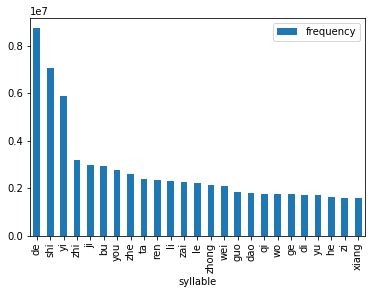

In [11]:
# Bar plot code
syllables.sort_values(by="frequency", axis=0, ascending=False).iloc[0:25, :].plot.bar(x="syllable", y="frequency")
plt.figure(figsize=(12*.75, 8*.75))
plt.show()

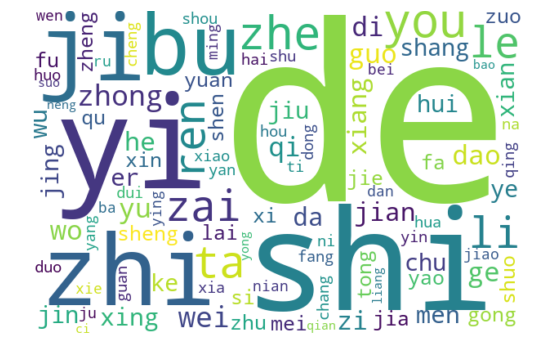

In [9]:
# Wordcloud code
syllcloud = wc.WordCloud(
    max_font_size=300, 
    max_words=100, 
    background_color="white", 
    width=600, 
    height=400).generate_from_frequencies(syll_dict)
plt.figure(figsize=(12*.75, 8*.75))
plt.imshow(syllcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
# Save the wordcloud image:
syllcloud.to_file("syllcloud.png")

From our barplot and wordcloud, we can see that "de" is the most common syllable, followed by "shi" and "yi". Notice how syllables either end in a vowel, "n", or "ng". Compared to English, there are much fewer ways to make a proper syllable, and there are basically no real consonant clusters. (The velar nasal - "ng", the retroflex - "sh", while orthographically appear to consist of two consonants, are actually considered singular phonemes linguistically, as opposed to something like "sk".)

Most Chinese IMEs don't differentiate between tones, so we won't either. We'll make a new column called "toneless" which contains the pinyin without tone marks generated using Unidecode.

In [15]:
# Use unidecode to get rid of tone marks, add a new column without tone marks
toneless = np.array([])
for p in characters["pinyin"]:              
    toneless = np.append(toneless, unidecode.unidecode(p))
characters["toneless"] = toneless
characters.head()

,frequency_rank,character,pinyin,toneless
0,1,的,de,de
1,2,一,yī,yi
2,3,是,shì,shi
3,4,不,bù,bu
4,5,了,le,le


In [40]:
# Save as a .csv file so that as many people can run our script without installing unidecode
characters.to_csv("../data/character ranking toneless.csv", encoding="utf-8")

Now let's walk through the intuition behind the IME. Let's say we type in "yi" into the IME. Ideally the IME should retrieve all the characters corresponding to "yi" in order of usage frequency.

Take a look at the dataframe. First, let's get all the rows that have the same toneless pinyin "yi." There are 159 rows, but thankfully, they are already sorted by frequency. But if they weren't, we could just sort them using the Pandas sort() function.

In [29]:
yi = characters.loc[characters["toneless"] == "yi", :]
yi.head()

,frequency_rank,character,pinyin,toneless
1,2,一,yī,yi
22,23,以,yǐ,yi
101,2,一,yī,yi
122,23,以,yǐ,yi
203,104,意,yì,yi


Now we want to save the "yi" characters into a list. There are some duplicates, so we'll only save the unique characters.

In [30]:
yi_characters = list(yi["character"].unique())

Now let's write the function that creates the character dictionary from the character dataframe.

For the character dictionary, we're going to have the toneless pinyin as the keys, and the corresponding character lists as the values.

In [16]:
# Function to create character dictionary from dataframe
def character_dict(df):
    # Takes in df containing 4 columns: frequency_rank, character, pinyin, toneless
    # Returns dictionary with toneless pinyin as the keys, list of corr. characters as values
    # Initialize dictionary
    chars = dict()
    # Get unique list of toneless pinyin
    unique_pinyin = df["toneless"].unique()
    for u in unique_pinyin:
        # Get all rows that have toneless pinyin u
        u_rows = df.loc[df["toneless"] == u, :]
        # Save u characters into a list, only save the unique characters
        u_list = list(u_rows["character"].unique())
        # Set u as key, the list as value
        chars[u] = u_list
    # Return dictionary
    return chars

In [17]:
# Create the character dictionary!
char_dict = character_dict(characters)

<a name="spellcorrector"></a>
### Implementing the Pinyin Spelling Corrector for Syllables

In [28]:
# Returning probabilities of candidates
def P(syllable, N=sum(syll_dict.values())): 
    "Probability of `syllable`."
    return syll_dict[syllable] / N

# Returning the candidate with highest probability
def correction(syllable): 
    "Most probable spelling correction for syllable."
    return max(candidates(syllable), key=P)

# Getting all candidates (known syllables 0, 1, 2 edits away and the syllable itself)
def candidates(syllable): 
    "Generate possible spelling corrections for syllable."
    return (known([syllable]) or known(edits1(syllable)) or known(edits2(syllable)) or [syllable])

# Returning the syllables that are known
def known(syllables): 
    "The subset of `syllables` that appear in syll_dict."
    return set(s for s in syllables if s in syll_dict)

# One edit away
def edits1(syllable):
    "All edits that are one edit away from `syllable`."
    # Took away 'v' as it is not used in Hanyu Pinyin
    letters    = 'abcdefghijklmnopqrstuwxyz'
    splits     = [(syllable[:i], syllable[i:])    for i in range(len(syllable) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

# Two edits away
def edits2(syllable): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(syllable) for e2 in edits1(e1))

This is basically the same implementation as Peter Norvig's, but using our syll_dict instead. When I have more time, I would definitely look into improving the probabilities. It's already an improvement over some older IMEs that do not tolerate spelling errors well, but I'm still not sure if "dou" is a more realistic choice over "du" if I were to type "ddu". Certainly, the fact that there is a much more limited amount of syllables in Mandarin can be leveraged as well. In the future, I would also look to using Jun Da's bigram frequency data so that the IME can also handle bigrams. As of now, only one character can be processed at a time, and there is no support for special characters like punctuation marks yet either.

In [19]:
candidates("mieo")

{'miao', 'mie'}

In [20]:
correction("mieo")

'miao'

In [21]:
candidates("ddu")

{'diu', 'dou', 'du'}

In [22]:
correction("ddu")

'dou'

In [34]:
char_dict[correction("ddu")][0:10]

['都', '斗', '抖', '豆', '陡', '兜', '逗', '窦', '蚪', '痘']

<a name="interactivity"></a>
### Interactivity

I don't have a lot of experience in dashboard creation and interactive front-end in general, so I decided to see what I could do with ipywidgets. This is a really strange use of the widgets to the point where it's almost like a misuse, so it's definitely just a proof of concept. Since it's not built for this purpose, I did run into some limitations. Right now, it automatically selects the first character option. I've tried implementing code that would allow changing the character selection, but there was no way for it to stop listening to the changes. It makes sense if you were trying to toggle selections to manipuate a plot, but not for this purpose, because then the next character can't be inputted. However, it does fulfill the basic function of an IME. For those of you with better ipywidget knowledge, let me know if you have any suggestions, but I think a proper GUI is something I'll look into more.

In [36]:
from IPython.display import display

# Initialize widgets
output = widgets.Textarea(description = "Output: ")
pinyin = widgets.Text(description = "Pinyin Input: ")
select = widgets.Select(options=char_dict[correction("")], description = "Select: ")

# Pinyin handler after input is submitted
def pinyin_handler(sender):
    # # Reset select menu options
    select.index = None
    select.options = char_dict[correction(pinyin.value)]
    # Add selected character to output
    output.value = output.value + select.value
    # select.observe(on_click, "value")
    # Reset pinyin input box
    pinyin.value = ""

        

''''    
def on_click(change):
    output.value = output.value[:-1] + select.value
    pinyin.index = ""
'''''

# Display widgets
display(pinyin)
pinyin.on_submit(pinyin_handler)
display(select)
display(output)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

From what I know, the interface only displays correctly if you are running Jupyter Notebooks, so I've included a screen capture of its usage.
Below is a capture of me writing, "你好我是小唐", which means "Hello, I am Little Tang", using the IME.

In [38]:
from IPython.display import HTML
HTML('<img src="https://raw.githubusercontent.com/rtang18/xiaoshuru/master/notebooks/DesktopIME.gif.gif">')